In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from VLC_init import *
import scipy.fftpack
import cmath

In [2]:
"""
*: coordinate center of cari

|--------|                     
| car1   |                      
|-------*|
         |
       y |                   |---------|
         |                   |  car2   |
         |-------------------|*--------|
                    d

"""

'\n*: coordinate center of cari\n\n|--------|                     \n| car1   |                      \n|-------*|\n         |\n       y |                   |---------|\n         |                   |  car2   |\n         |-------------------|*--------|\n                    d\n\n'

In [3]:
#A_c = 20  # float(input('Enter carrier amplitude: '))
#f_c = 500000000000000  # float(input('Enter carrier frquency: '))
A_m = 0.9  # float(input('Enter message amplitude: '))
f_m1 = 40000000  # 40MHz 
f_m2 = 25000000 # 25MHz 
#modulation_index = 1  

dt = 1e-8; 
t = np.arange(0, 1e-3-dt, dt);
w1 = 2 * math.pi * f_m1
w2 = 2 * math.pi * f_m2
noise_standard_deviation = 1e-5

vlc_params = VLC_init()

delta_delay1 = (vlc_params.delays)[0][0] - (vlc_params.delays)[0][1]
delta_delay2 = vlc_params.delays[1][0] - vlc_params.delays[1][1]
#carrier = A_c * np.cos(2 * np.pi * f_c * t)
#modulator = A_m * np.cos(2 * np.pi * f_m * t)
#product = A_c * (1 + modulation_index * np.cos(2 * np.pi * f_m * t)) * np.cos(2 * np.pi * f_c * t)

#after going through ADC at receiver
s1_w1 = (A_m*np.cos(w1*(t - delta_delay1))+noise_standard_deviation*np.random.randn(1,len(t)))
s2_w1 = (A_m*np.cos(w1*(t))+noise_standard_deviation*np.random.randn(1,len(t)))

s1_w2 = (A_m*np.cos(w2*(t - delta_delay2))+noise_standard_deviation*np.random.randn(1,len(t)))
s2_w2 = (A_m*np.cos(w2*(t))+noise_standard_deviation*np.random.randn(1,len(t)))

In [4]:
s1_w1_fft = np.fft.fft(s1_w1)
s2_w1_fft = np.fft.fft(s2_w1)
s1_w1_fft[0,:len(s1_w1_fft[0])//2] = 0
s2_w1_fft[0,:len(s2_w1_fft[0])//2] = 0
s1_w1_upperSideband = np.fft.ifft(s1_w1_fft)
s2_w1_upperSideband = np.fft.ifft(s2_w1_fft)

s1_w2_fft = np.fft.fft(s1_w2)
s2_w2_fft = np.fft.fft(s2_w2)
s1_w2_fft[0,:len(s1_w2_fft[0])//2] = 0
s2_w2_fft[0,:len(s2_w2_fft[0])//2] = 0
s1_w2_upperSideband = np.fft.ifft(s1_w2_fft)
s2_w2_upperSideband = np.fft.ifft(s2_w2_fft)

In [5]:
direct_mix1      = np.multiply(s1_w1_upperSideband, s2_w1_upperSideband.conj());
delay1_measured  = np.angle(direct_mix1)/w1;

direct_mix2      = np.multiply(s1_w2_upperSideband, s2_w2_upperSideband.conj());
delay2_measured  = np.angle(direct_mix2)/w2;

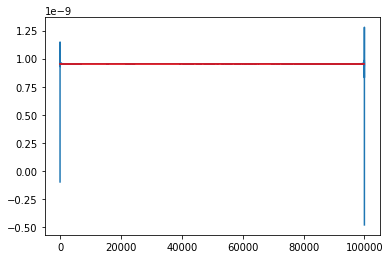

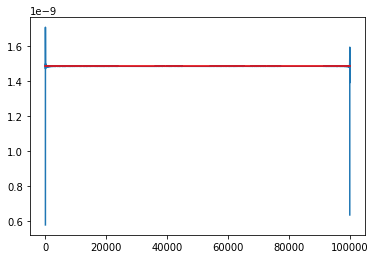

In [6]:
plt.figure()
#plt.xlim(20, 90000)
#plt.ylim(0.95e-9, 0.955e-9)
plt.plot(delay1_measured[0])
plt.plot([0, len(delay1_measured[0])-1],[delta_delay1, delta_delay1], color ="red")
plt.show()

plt.figure()
plt.plot(delay2_measured[0])
plt.plot([0, len(delay2_measured[0])-1],[delta_delay2, delta_delay2], color ="red")
plt.show()

In [8]:
print(delta_delay1)
print(np.mean(delay1_measured))

print(delta_delay2)
print(np.mean(delay2_measured))

9.53817645139062e-10
9.537986204393001e-10
1.4859569590359915e-09
1.4859394809011695e-09


In [22]:
#phase1 = np.mean(np.angle(direct_mix1))
#phase2 = np.mean(np.angle(direct_mix1))

#calculate distance differences using d(dist) = delay * c
v = 3*1e8
ddist1 = np.mean(delay1_measured) * v
ddist2 = np.mean(delay2_measured) * v

Y_A = vlc_params.distancecar
D = vlc_params.distancecar

if abs(ddist1) > 1e-5 and abs(ddist2) > 1e-5:
    print("entered to if")
    A = Y_A ** 2 * (1 / (ddist1 ** 2) - 1 / (ddist2 ** 2))
    
    B1 = (-(Y_A**3) + 2*(Y_A**2)*D + Y_A*(ddist1**2))/(ddist1**2)
    B2 = (-(Y_A**3) + Y_A*(ddist2**2))/(ddist2**2)
    B = B1 - 2*D - B2
    
    C1 = ((Y_A**4) + 4*(D**2)*(Y_A**2) + (ddist1**4) - 4*D*(Y_A**3) - 2*(Y_A**2)*(ddist1**2) + 4*D*Y_A*(ddist1**2)) / (4*(ddist1**2))
    C2 = ((Y_A**4) + (ddist2**4) - 2*(Y_A**2)*(ddist2**2)) / (4*(ddist2**2))
    C = C1 - D**2 - C2
    
    if ddist1 * ddist2 > 0:
        Y_B = (- B - math.sqrt(B**2 - 4*A*C)) / (2*A)
    else:
        Y_B = (- B + math.sqrt(B**2 - 4*A*C)) / (2*A)
    X_A = - math.sqrt(((Y_A**2 - 2*Y_A*Y_B - ddist2**2) / (2*ddist2)) ** 2 - (Y_B**2))
elif abs(ddist1) < 1e-5:
    print("entered to elif")
    Y_B = Y_A / 2 - D
    X_A = - math.sqrt(((2*D*Y_A - ddist2**2) / (2-ddist2))**2 - (D - Y_A/2)**2)
else:
    print("entered to else")
    Y_B = Y_A / 2
    X_A = - math.sqrt(((2*Y_A*D + ddist1**2) / (2*ddist1))**2 - (D + Y_A/2)**2)
print(Y_B)
print(X_A)

entered to if
-1.9999735362161046
-5.000020516481955
